# Prediciting high school graduation rate of a cohort based on holistic data of the student population and school.

What do variables about:
- the broader structure of a school
- the experience of previous cohorts
- the freshmen, sophomore and junior year experience of rising seniors
tell us about the graduating % of rising seniors?

Data was gathered from https://www.isbe.net/pages/illinois-state-report-card-data.aspx
I have collected end of year data for the following academic years:
- 2018/19
- 2017/18
- 2016/17
- 2015/16
- 2014/15
- 2013/14
- 2012/13

I will look at the following cohorts for training the data:

- Class of 2017
- Class of 2016

and follow them thru their 4 years of high school (grades 9-12)

I will run validation on 
- Class of 2018

My test set with be 
- Class of 2019

The goal is to predict the 4-year high school graduation rate for this cohort.

# Sections
[Cleaning and exploring datasets](#Cleaning-and-exploring-datasets)
- [Class of 2019](#Class-of-2019)
- [Class of 2018](#Class-of-2018)
- [Class of 2017](#Class-of-2017)
- [Class of 2016](#Class-of-2016)
- [Class of 2015](#Class-of-2015)
- [Class of 2014](#Class-of-2014)
- [Class of 2013](#Class-of-2013)

[Concatenate dataframes](#Concatenate-dataframes)

[EDA on merged dataframe](#EDA-on-merged-dataframe)




## Cleaning and exploring datasets

Gathering the data for each of the academic years 2013 - 2017 involved downloading semi-colon separated .txt files, importing them into a spreadsheet, then matching the columns to headers that were recorded in a separate .xls file. While performing this task, I also selected feature set to use for this project.

I also added a column to every academic year to identify the cohort by their graduation year (e.g. 2018). 

I will create a matrix of the information for each cohort.

In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

# turn off warnings
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = FutureWarning)

# import additional libraries
import pandasql as ps
from pandasql import sqldf

import statsmodels.api as sm
from statsmodels.formula.api import ols

# pysqldf lambda function
pysqldf = lambda q: sqldf(q, globals())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# eda function
def proj_eda(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)

In [3]:
def clean_col(df):

    df.columns = [x.lower()
                 .replace("-", " ")
                 .replace("  ", " ")
                 .replace(" ", "_")
                 .replace("__", "_")
                 .rstrip()
                 .replace("#", "number")
                 .replace("%", "percent") for x in df.columns]
    return df.columns.to_list()

In [4]:
# plot parameters
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16

In [5]:
# heatmap function
def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(10, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='YlGnBu', 
                    cbar=False,
                    vmin=-1,
                    vmax=1)  
    return g

In [6]:
# forward selected function

import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

### Step 1
create a dataframe for each academic year for schools that serve grades 9 - 12.
This will include traditional high schools and some charter schools that serve grades in addition to 9 - 12. This may have an impact on features such as the total number of students in a school, attendance rate and I will have to be aware and make corrections if needed.

### Class of 2019

In [7]:
df_19 = pd.read_excel('../../data/2019-Report-Card-Public-Data-Set_clean.xlsx', sheet_name="General")
df_19.shape

(4738, 35)

In [8]:
clean_col(df_19)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [9]:
# create query to return schools with grades 9-12

q1 = """SELECT * 
       FROM df_19
       WHERE grades_served LIKE "%12%";"""

hs_19 = pysqldf(q1)

In [10]:
hs_19.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2019,010010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,86.8,2.0,68.8,68.8,95.6,NaN,NaN,NaN
1,2019,010010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,83.9,2.0,58.1,58.1,94.0,NaN,NaN,NaN
2,2019,010010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,83.3,2.0,75.0,73.3,94.9,NaN,NaN,NaN
3,2019,010010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,86.4,1.0,60.7,60.7,92.9,NaN,NaN,27.0
4,2019,010011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,9 10 11 12,...,None,None,86.4,2.0,67.7,65.7,74.9,68.0,127.0,126.0


In [11]:
hs_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      720 non-null    int64  
 1   rcdts                                                                       720 non-null    object 
 2   school_name                                                                 720 non-null    object 
 3   district                                                                    720 non-null    object 
 4   city                                                                        720 non-null    object 
 5   county                                                                      720 non-null    object 
 6   district_type                                     

There are some columns that are have nulls. I am going to have to fix those.

the `percentage_student_enrollment`... nulls can be changed to zero.
I am assuming the same can be applied to columns 31-34. 

Will need to investigate further to see why there are missing values in 18-30.

In [12]:
hs_19.percent_student_enrollment_white.isna().sum()

38

In [13]:
hs_19.percent_student_enrollment_white.sort_values(na_position='first')

191      NaN
196      NaN
197      NaN
199      NaN
206      NaN
       ...  
159    100.0
179    100.0
454    100.0
166    100.0
422    100.0
Name: percent_student_enrollment_white, Length: 720, dtype: float64

In [14]:
hs_19.percent_student_enrollment_white.replace(np.nan, 0, inplace=True)

In [15]:
hs_19.percent_student_enrollment_white.isna().sum()

0

OK. that did the trick. Time to do the same for the other enrollment columns

In [16]:
hs_19.percent_student_enrollment_black_or_african_american.replace(np.nan, 0, inplace=True)
hs_19.percent_student_enrollment_hispanic_or_latino.replace(np.nan, 0, inplace=True)
hs_19.percent_student_enrollment_asian.replace(np.nan, 0, inplace=True)
hs_19.percent_student_enrollment_native_hawaiian_or_other_pacific_islander.replace(np.nan, 0, inplace=True)
hs_19.percent_student_enrollment_american_indian_or_alaska_native.replace(np.nan, 0, inplace=True)
hs_19.percent_student_enrollment_two_or_more_races.replace(np.nan, 0, inplace=True)

...and the AP classes columns

In [17]:
hs_19.number_students_who_took_ap_classes_grade_10_total.replace(np.nan, 0, inplace=True)
hs_19.number_students_who_took_ap_classes_grade_11_total.replace(np.nan, 0, inplace=True)
hs_19.number_students_who_took_ap_classes_grade_12_total.replace(np.nan, 0, inplace=True)

In [18]:
hs_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      720 non-null    int64  
 1   rcdts                                                                       720 non-null    object 
 2   school_name                                                                 720 non-null    object 
 3   district                                                                    720 non-null    object 
 4   city                                                                        720 non-null    object 
 5   county                                                                      720 non-null    object 
 6   district_type                                     

### Class of 2018

In [19]:
df_18 = pd.read_excel('../../data/2018-Report-Card-Public-Data-Set_clean.xlsx', sheet_name="General")
df_18.shape

(4754, 35)

In [20]:
clean_col(df_18)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [21]:
q2 = """SELECT * 
       FROM df_18
       WHERE grades_served LIKE "%12%";"""

hs_18 = pysqldf(q2)

In [22]:
hs_18.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2018,010010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,90.6,2.0,81.5,81.5,100.0,NaN,NaN,NaN
1,2018,010010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,84.8,2.0,80.4,80.4,93.0,NaN,NaN,NaN
2,2018,010010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,83.7,1.0,75.0,75.0,94.0,NaN,NaN,NaN
3,2018,010010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,83.7,1.0,74.0,72.0,80.0,NaN,NaN,20.0
4,2018,010011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,9 10 11 12,...,None,None,81.9,3.0,68.9,68.2,51.0,109.0,110.0,148.0


In [23]:
hs_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      721 non-null    int64  
 1   rcdts                                                                       721 non-null    object 
 2   school_name                                                                 721 non-null    object 
 3   district                                                                    721 non-null    object 
 4   city                                                                        721 non-null    object 
 5   county                                                                      721 non-null    object 
 6   district_type                                     

Going to do the same clean up on hs_18

In [24]:
hs_18.percent_student_enrollment_white.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_black_or_african_american.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_hispanic_or_latino.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_asian.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_native_hawaiian_or_other_pacific_islander.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_american_indian_or_alaska_native.replace(np.nan, 0, inplace=True)
hs_18.percent_student_enrollment_two_or_more_races.replace(np.nan, 0, inplace=True)
hs_18.number_students_who_took_ap_classes_grade_10_total.replace(np.nan, 0, inplace=True)
hs_18.number_students_who_took_ap_classes_grade_11_total.replace(np.nan, 0, inplace=True)
hs_18.number_students_who_took_ap_classes_grade_12_total.replace(np.nan, 0, inplace=True)

In [25]:
hs_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      721 non-null    int64  
 1   rcdts                                                                       721 non-null    object 
 2   school_name                                                                 721 non-null    object 
 3   district                                                                    721 non-null    object 
 4   city                                                                        721 non-null    object 
 5   county                                                                      721 non-null    object 
 6   district_type                                     

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


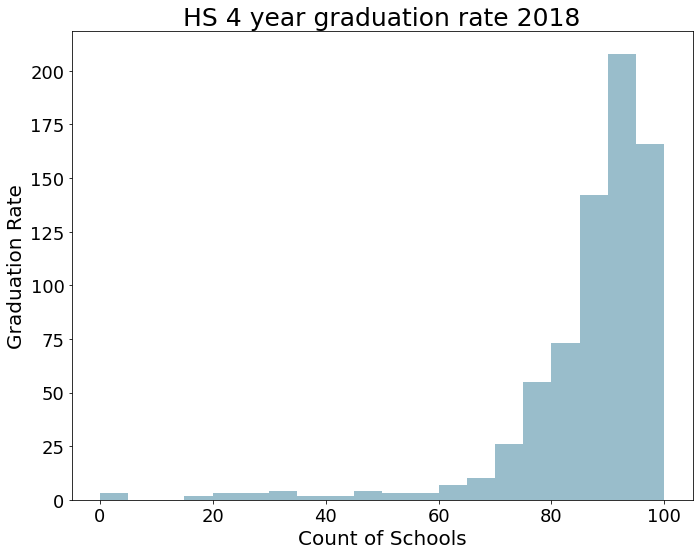

In [26]:
fig = plt.subplots(figsize=(10,8))
plt.hist(hs_18.high_school_4_year_graduation_rate_total, bins = 20, color='#99BDCB')
plt.title('HS 4 year graduation rate 2018')
plt.xlabel('Count of Schools')
plt.ylabel('Graduation Rate')
plt.tight_layout()
plt.savefig('figures/2018_hist.png')
plt.show();

### Class of 2017

In [27]:
df_17 = pd.read_excel('../../data/2017-Report-Card-Public-Data-Set_clean.xlsx')
df_17.shape

(3796, 35)

In [28]:
clean_col(df_17)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [29]:
q3 = """SELECT * 
       FROM df_17
       WHERE grades_served LIKE "%12%";"""

hs_17 = pysqldf(q3)

In [30]:
hs_17.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2017,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,10.1,"$36,294",87.5,2,66.7,66.7,84.6,0,0,0
1,2017,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,23.5,"$41,061",71.1,2,70.8,66.7,89.1,0,0,0
2,2017,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,12.8,"$45,975",71.4,2,73.2,64.3,89.1,0,0,0
3,2017,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,17.5,"$40,873",82.1,1,64.1,59,84.3,0,0,18
4,2017,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,9 10 11 12,...,28.5,"$41,946",77.4,2,69.8,65.1,63.1,93,122,125


In [31]:
hs_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      712 non-null    int64  
 1   rcdts                                                                       712 non-null    object 
 2   school_name                                                                 712 non-null    object 
 3   district                                                                    712 non-null    object 
 4   city                                                                        712 non-null    object 
 5   county                                                                      712 non-null    object 
 6   district_type                                     

Columns 21-34 should be floats, not objects

In [32]:
cols = ['high_school_dropout_rate_total',
                 'high_school_4_year_graduation_rate_total',
                 'high_school_5_year_graduation_rate_total',
                 'avg_class_size_high_school',
                 'pupil_teacher_ratio_high_school',
                 'teacher_avg_salary',
                 'teacher_retention_rate',
                 'principal_turnover_within_6_years',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
                 'percent_9th_grade_on_track',
                 'number_students_who_took_ap_classes_grade_10_total',
                 'number_students_who_took_ap_classes_grade_11_total',
                 'number_students_who_took_ap_classes_grade_12_total']


hs_17[cols] = hs_17[cols].apply(pd.to_numeric, errors='coerce', axis=1)
        

In [33]:
hs_17.high_school_dropout_rate_total.unique()

array([ 0.7,  0. ,  0.8,  0.4,  1.9,  1.6,  0.5,  1.4,  2.9,  3.5,  3.8,
        2.2,  1.5,  2.6,  1.1,  2.7,  3.3,  0.9,  2.3,  1. ,  0.6,  1.2,
        5.2,  7.5,  3. ,  4.7,  3.2,  1.3,  0.1,  0.3,  0.2,  8. ,  1.8,
        3.1,  2.5,  1.7,  5.5,  2.4,  3.6, 18.4,  2. ,  5. ,  2.1,  8.5,
        4.1,  3.9, 48.1, 45.4, 33.6, 66.2, 49.4, 62.2, 44.2, 40.2, 65. ,
       39.6, 57.7, 45.2, 38.1,  4.3, 55.6, 53.6, 56.6, 28.4,  9.9,  7.8,
        3.4, 40.8,  nan, 17. ,  2.8,  7.1, 10.9,  4. ,  4.4,  4.6, 10.3,
       15.3,  4.5,  3.7, 13.2,  6.9,  5.3,  5.6, 21.2,  6.6])

It looks like there are some hidden empty strings in here. Need to convert those to nans, then figure out how to handle those...

In [34]:
hs_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      712 non-null    int64  
 1   rcdts                                                                       712 non-null    object 
 2   school_name                                                                 712 non-null    object 
 3   district                                                                    712 non-null    object 
 4   city                                                                        712 non-null    object 
 5   county                                                                      712 non-null    object 
 6   district_type                                     

In [35]:
# replacing nans with zeros
hs_17.number_students_who_took_ap_classes_grade_10_total.replace(np.nan, 0, inplace=True)
hs_17.number_students_who_took_ap_classes_grade_11_total.replace(np.nan, 0, inplace=True)
hs_17.number_students_who_took_ap_classes_grade_12_total.replace(np.nan, 0, inplace=True)

In [36]:
hs_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      712 non-null    int64  
 1   rcdts                                                                       712 non-null    object 
 2   school_name                                                                 712 non-null    object 
 3   district                                                                    712 non-null    object 
 4   city                                                                        712 non-null    object 
 5   county                                                                      712 non-null    object 
 6   district_type                                     

### Class of 2016

In [37]:
df_16 = pd.read_excel('../../data/2016-Report-Card-Public-Data-Set_clean.xlsx')
df_16.shape

(3735, 35)

In [38]:
clean_col(df_16)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [39]:
q4 = """SELECT * 
       FROM df_16
       WHERE grades_served LIKE "%12%";"""

hs_16 = pysqldf(q4)

In [40]:
hs_16.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2016,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,8.4,"$34,801",82.1,3,65,65,77.8,0,0,0
1,2016,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,16.7,"$40,883",76.8,1,77.3,70.5,97.9,,,
2,2016,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,13.7,"$46,882",77.4,2,76.7,70,94.3,0,0,0
3,2016,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,15.6,"$40,823",80.3,1,63.6,60,84.4,0,0,21
4,2016,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,26.4,"$44,780",79.6,2,62.2,57.1,,144,161,157


In [41]:
hs_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      670 non-null    int64  
 1   rcdts                                                                       670 non-null    object 
 2   school_name                                                                 670 non-null    object 
 3   district                                                                    670 non-null    object 
 4   city                                                                        670 non-null    object 
 5   county                                                                      670 non-null    object 
 6   district_type                                     

In [42]:
cols = ['high_school_dropout_rate_total',
                 'high_school_4_year_graduation_rate_total',
                 'high_school_5_year_graduation_rate_total',
                 'avg_class_size_high_school',
                 'pupil_teacher_ratio_high_school',
                 'teacher_avg_salary',
                 'teacher_retention_rate',
                 'principal_turnover_within_6_years',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
                 'percent_9th_grade_on_track',
                 'number_students_who_took_ap_classes_grade_10_total',
                 'number_students_who_took_ap_classes_grade_11_total',
                 'number_students_who_took_ap_classes_grade_12_total']


hs_16[cols] = hs_16[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [43]:
hs_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      670 non-null    int64  
 1   rcdts                                                                       670 non-null    object 
 2   school_name                                                                 670 non-null    object 
 3   district                                                                    670 non-null    object 
 4   city                                                                        670 non-null    object 
 5   county                                                                      670 non-null    object 
 6   district_type                                     

In [44]:
# replacing nans with zeros
hs_16.number_students_who_took_ap_classes_grade_10_total.replace(np.nan, 0, inplace=True)
hs_16.number_students_who_took_ap_classes_grade_11_total.replace(np.nan, 0, inplace=True)
hs_16.number_students_who_took_ap_classes_grade_12_total.replace(np.nan, 0, inplace=True)

### Class of 2015


In [45]:
df_15 = pd.read_excel('../../data/2015-Report-Card-Public-Data-Set_clean.xlsx')
df_15.shape

(3764, 35)

In [46]:
clean_col(df_15)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [47]:
q5 = """SELECT * 
       FROM df_15
       WHERE grades_served LIKE "%12%";"""

hs_15 = pysqldf(q5)

In [48]:
hs_15.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2015,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,7.6,"$33,771",73.7,3,72.7,69.7,93,None,None,None
1,2015,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,17.2,"$41,447",74.1,1,81.6,77.6,97.4,None,None,None
2,2015,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,15.1,"$46,534",74.6,2,64.1,60.9,95.8,None,None,None
3,2015,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,14.4,"$40,549",82,1,69.8,69.8,71.7,None,None,None
4,2015,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,22.6,"$44,849",81.7,2,66.2,62.7,,None,None,None


In [49]:
hs_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      671 non-null    int64  
 1   rcdts                                                                       671 non-null    object 
 2   school_name                                                                 671 non-null    object 
 3   district                                                                    671 non-null    object 
 4   city                                                                        671 non-null    object 
 5   county                                                                      671 non-null    object 
 6   district_type                                     

In [50]:
cols = ['high_school_dropout_rate_total',
                 'high_school_4_year_graduation_rate_total',
                 'high_school_5_year_graduation_rate_total',
                 'avg_class_size_high_school',
                 'pupil_teacher_ratio_high_school',
                 'teacher_avg_salary',
                 'teacher_retention_rate',
                 'principal_turnover_within_6_years',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
                 'percent_9th_grade_on_track',
                 'number_students_who_took_ap_classes_grade_10_total',
                 'number_students_who_took_ap_classes_grade_11_total',
                 'number_students_who_took_ap_classes_grade_12_total']


hs_15[cols] = hs_15[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [51]:
hs_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      671 non-null    int64  
 1   rcdts                                                                       671 non-null    object 
 2   school_name                                                                 671 non-null    object 
 3   district                                                                    671 non-null    object 
 4   city                                                                        671 non-null    object 
 5   county                                                                      671 non-null    object 
 6   district_type                                     

### Class of 2014

In [52]:
df_14 = pd.read_excel('../../data/2014-Report-Card-Public-Data-Set_clean.xlsx')
df_14.shape

(3794, 35)

In [53]:
clean_col(df_14)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [54]:
q6 = """SELECT * 
       FROM df_14
       WHERE grades_served LIKE "%12%";"""

hs_14 = pysqldf(q6)

In [55]:
hs_14.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2014,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,9.7,"$40,711",69.5,2,None,None,None,None,None,None
1,2014,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,14.8,"$40,764",86,1,None,None,None,None,None,None
2,2014,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,12.4,"$46,756",80,2,None,None,None,None,None,None
3,2014,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,13.4,"$40,744",81.7,1,None,None,None,None,None,None
4,2014,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,19.1,"$44,812",87.6,3,None,None,None,None,None,None


In [56]:
hs_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      675 non-null    int64  
 1   rcdts                                                                       675 non-null    object 
 2   school_name                                                                 675 non-null    object 
 3   district                                                                    675 non-null    object 
 4   city                                                                        675 non-null    object 
 5   county                                                                      675 non-null    object 
 6   district_type                                     

In [57]:
cols = ['high_school_dropout_rate_total',
                 'high_school_4_year_graduation_rate_total',
                 'high_school_5_year_graduation_rate_total',
                 'avg_class_size_high_school',
                 'pupil_teacher_ratio_high_school',
                 'teacher_avg_salary',
                 'teacher_retention_rate',
                 'principal_turnover_within_6_years',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
                 'percent_9th_grade_on_track',
                 'number_students_who_took_ap_classes_grade_10_total',
                 'number_students_who_took_ap_classes_grade_11_total',
                 'number_students_who_took_ap_classes_grade_12_total']


hs_14[cols] = hs_14[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [58]:
hs_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      675 non-null    int64  
 1   rcdts                                                                       675 non-null    object 
 2   school_name                                                                 675 non-null    object 
 3   district                                                                    675 non-null    object 
 4   city                                                                        675 non-null    object 
 5   county                                                                      675 non-null    object 
 6   district_type                                     

### Class of 2013

In [59]:
df_13 = pd.read_excel('../../data/2013-Report-Card-Public-Data-Set_clean.xlsx')
df_13.shape

(3862, 35)

In [60]:
clean_col(df_13)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [61]:
q7 = """SELECT * 
       FROM df_13
       WHERE grades_served LIKE "%12%";"""

hs_13 = pysqldf(q7)

In [62]:
hs_13.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2013,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,SMALL,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
1,2013,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
2,2013,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
3,2013,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
4,2013,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,None,None,None,None,None,None,None,None,None,None


In [63]:
hs_13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      675 non-null    int64  
 1   rcdts                                                                       675 non-null    object 
 2   school_name                                                                 675 non-null    object 
 3   district                                                                    675 non-null    object 
 4   city                                                                        675 non-null    object 
 5   county                                                                      675 non-null    object 
 6   district_type                                     

In [64]:
cols = ['high_school_dropout_rate_total',
                 'high_school_4_year_graduation_rate_total',
                 'high_school_5_year_graduation_rate_total',
                 'avg_class_size_high_school',
                 'pupil_teacher_ratio_high_school',
                 'teacher_avg_salary',
                 'teacher_retention_rate',
                 'principal_turnover_within_6_years',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
                 'percent_9th_grade_on_track',
                 'number_students_who_took_ap_classes_grade_10_total',
                 'number_students_who_took_ap_classes_grade_11_total',
                 'number_students_who_took_ap_classes_grade_12_total']


hs_13[cols] = hs_13[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [65]:
hs_13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 35 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      675 non-null    int64  
 1   rcdts                                                                       675 non-null    object 
 2   school_name                                                                 675 non-null    object 
 3   district                                                                    675 non-null    object 
 4   city                                                                        675 non-null    object 
 5   county                                                                      675 non-null    object 
 6   district_type                                     

## Concatenate dataframes 
create a matrix where one row is the cohort of a school (e.g. cohort 2018 for school xxx1, cohort 2017 for xxx1, cohort 2018 for school yyy2, cohort 2017 for school yyy2).

In [66]:
columns_check= list(hs_19.columns)

dataframes_check = [hs_13,hs_14, hs_15, hs_16, hs_17, hs_18]
missing = {}
for idx, dataframe in enumerate(dataframes_check):
    missing_columns = [x for x in columns_check if x not in dataframes_check[idx].columns]
    if missing_columns:
        missing[idx]=missing_columns

In [67]:
missing

{}

In [68]:
final_features=['cohort','rcdts','school_name','district','city','county','district_type', 'district_size',
                'school_type','grades_served','percent_student_enrollment_white',
                'percent_student_enrollment_black_or_african_american',
                'percent_student_enrollment_hispanic_or_latino','percent_student_enrollment_asian',
                'percent_student_enrollment_native_hawaiian_or_other_pacific_islander','percent_student_enrollment_american_indian_or_alaska_native','percent_student_enrollment_two_or_more_races',
                'number_student_enrollment','total_number_of_school_days','student_attendance_rate','student_chronic_truancy_rate',
                'high_school_dropout_rate_total','high_school_4_year_graduation_rate_total','high_school_5_year_graduation_rate_total',
                'avg_class_size_high_school','pupil_teacher_ratio_high_school','teacher_retention_rate',
                'principal_turnover_within_6_years','percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months','percent_9th_grade_on_track',
                'number_students_who_took_ap_classes_grade_10_total','number_students_who_took_ap_classes_grade_11_total',
                'number_students_who_took_ap_classes_grade_12_total']
final_features
all_dfs=[hs_13, hs_14, hs_15, hs_16, hs_17]
filtered_dfs=[]

for dataframe in all_dfs:
    filtered_dfs.append(dataframe[final_features])
    
merged_df = pd.concat(all_dfs) 

## EDA on merged dataframe
additional cleaning and sorting 

In [69]:
proj_eda(merged_df)

,null_sum,null_pct,dtypes,count,mean,median,min,max
avg_class_size_high_school,34,0.009991,float64,3369,17.466043,17.7,0.3,81
city,0,0.000000,object,3403,NaN,NaN,Abingdon,Zion
cohort,0,0.000000,int64,3403,2015.020276,2015.0,2013,2017
county,0,0.000000,object,3403,NaN,NaN,Adams,Woodford
district,0,0.000000,object,3403,NaN,NaN,A-C Central CUSD 262,Zion-Benton Twp HSD 126
district_size,0,0.000000,object,3403,NaN,NaN,LARGE,SMALL
district_type,0,0.000000,object,3403,NaN,NaN,HIGH SCHOOL,UNIT
grades_served,0,0.000000,object,3403,NaN,NaN,10 11 12,PK K 1 2 3 4 5 6 7 8 9 10 11 12
high_school_4_year_graduation_rate_total,19,0.005583,float64,3384,85.283008,88.5,0,100
high_school_5_year_graduation_rate_total,60,0.017632,float64,3343,87.718516,90.3,2.6,100


I may almost be done cleaning, right?

In [70]:
# cohort should be a category
merged_df['cohort'] = merged_df['cohort'].astype('category')
# check that again
list(merged_df.select_dtypes(['object', 'bool', 'category']))

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'student_chronic_truancy_rate']

Now to make some decisions about features to keep and dealing with nans

In [73]:
merged_df.isnull().sum().sort_values(ascending=False)

teacher_avg_salary                                                            3403
number_students_who_took_ap_classes_grade_12_total                            2021
number_students_who_took_ap_classes_grade_11_total                            2021
number_students_who_took_ap_classes_grade_10_total                            2021
percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months    1440
percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months    1440
percent_9th_grade_on_track                                                    1411
principal_turnover_within_6_years                                              753
teacher_retention_rate                                                         732
pupil_teacher_ratio_high_school                                                682
high_school_5_year_graduation_rate_total                                        60
avg_class_size_high_school                                                      34
high

Starting from the top down:
- Avg teacher salary will be dropped. The data is recorded at the disctrict level, but not by school. Also I've reconsidered the usefulness of that item
- AP classes. I feel like this is important. It wasn't entered for 2013 or 2014, which is a lot of missing values. I will replace the NaNs with the mean for the time being. I will also consider running a model without them to see what impact they have.
- Percent of Graduates columns. Replace with mean.
- Percent of 9th graders. Replace with mean.
- Principal turnover. I'm going to drop. Like teacher salary, I'm not sure how important it really is.
- Teacher retention rate. Replace with mean. I feel like this is more important than principal turnover.
- Pupil:Teacher ratio. Replace with mean.
- 5 year graduation rate. Replace with mean.
- Avg class size. Replace with mean.
- Dropout rate. Replace with mean.

- 4 year grad rate. Since this is the target, I need to do some more digging and try to find a real explanation for these Nana




In [74]:
merged_df = merged_df.drop(['teacher_avg_salary', 'principal_turnover_within_6_years'], axis=1)

# Find the missing 4 year grad values. Don't include them in the Mean Replacer

In [75]:
nans = merged_df.loc[:, ('high_school_dropout_rate_total', 
        'high_school_4_year_graduation_rate_total',
        'high_school_5_year_graduation_rate_total',
        'avg_class_size_high_school',
        'pupil_teacher_ratio_high_school',
        'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
        'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
        'percent_9th_grade_on_track', 
        'teacher_retention_rate', 
        'number_students_who_took_ap_classes_grade_10_total',
        'number_students_who_took_ap_classes_grade_11_total',
        'number_students_who_took_ap_classes_grade_12_total')]

for nan in nans:
    merged_df[nan].fillna(merged_df[nan].mean(), inplace=True)

In [76]:
merged_df.isnull().sum().sort_values(ascending=False)

number_students_who_took_ap_classes_grade_12_total                            0
percent_student_enrollment_american_indian_or_alaska_native                   0
rcdts                                                                         0
school_name                                                                   0
district                                                                      0
city                                                                          0
county                                                                        0
district_type                                                                 0
district_size                                                                 0
school_type                                                                   0
grades_served                                                                 0
percent_student_enrollment_white                                              0
percent_student_enrollment_black_or_afri

In [77]:
proj_eda(merged_df)

,null_sum,null_pct,dtypes,count,mean,median,min,max
avg_class_size_high_school,0,0.0,float64,3403,17.466043,17.600000,0.3,81
city,0,0.0,object,3403,NaN,NaN,Abingdon,Zion
cohort,0,0.0,category,3403,NaN,NaN,NaN,NaN
county,0,0.0,object,3403,NaN,NaN,Adams,Woodford
district,0,0.0,object,3403,NaN,NaN,A-C Central CUSD 262,Zion-Benton Twp HSD 126
district_size,0,0.0,object,3403,NaN,NaN,LARGE,SMALL
district_type,0,0.0,object,3403,NaN,NaN,HIGH SCHOOL,UNIT
grades_served,0,0.0,object,3403,NaN,NaN,10 11 12,PK K 1 2 3 4 5 6 7 8 9 10 11 12
high_school_4_year_graduation_rate_total,0,0.0,float64,3403,85.283008,88.500000,0,100
high_school_5_year_graduation_rate_total,0,0.0,float64,3403,87.718516,90.100000,2.6,100


### Step 4 check correlations


In [91]:
num_features = merged_df.select_dtypes(['float64', 'int64'])

In [92]:
num_features.corr()['high_school_4_year_graduation_rate_total']

percent_student_enrollment_white                                              0.328191
percent_student_enrollment_black_or_african_american                         -0.342726
percent_student_enrollment_hispanic_or_latino                                -0.122076
percent_student_enrollment_asian                                              0.163495
percent_student_enrollment_native_hawaiian_or_other_pacific_islander          0.006480
percent_student_enrollment_american_indian_or_alaska_native                  -0.002505
percent_student_enrollment_two_or_more_races                                  0.001653
number_student_enrollment                                                     0.052990
total_number_of_school_days                                                  -0.091067
student_attendance_rate                                                       0.567331
high_school_dropout_rate_total                                               -0.611491
high_school_4_year_graduation_rate_total   

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  This is separate from the ipykernel package so we can avoid doing imports until


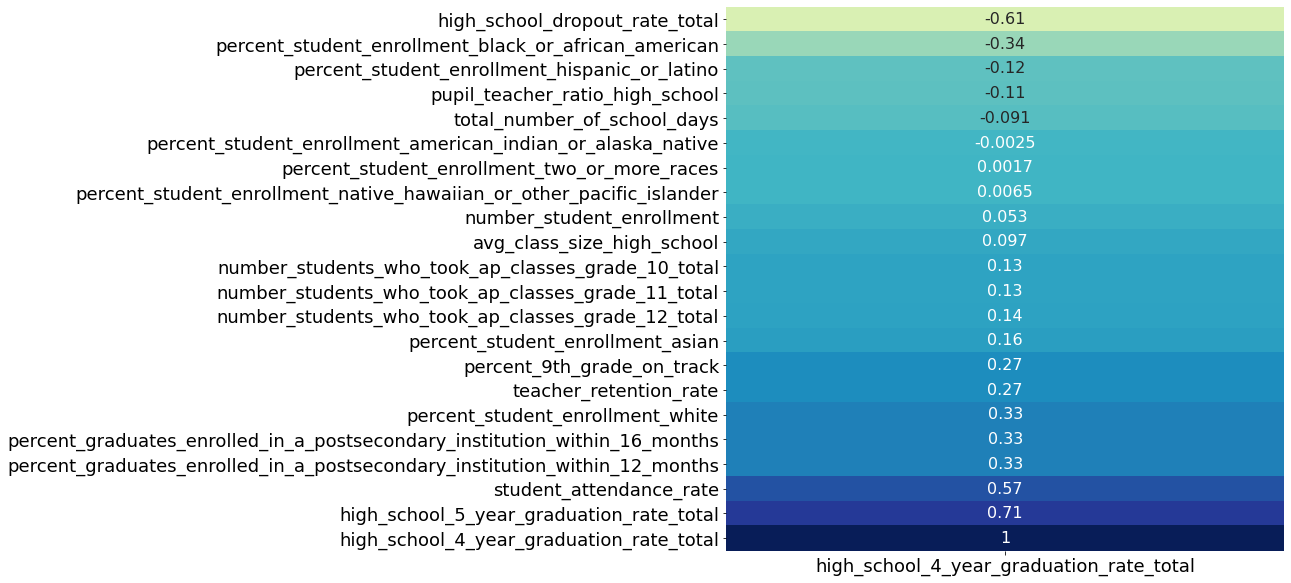

In [93]:
heatmap_numeric_w_dependent_variable(num_features, 'high_school_4_year_graduation_rate_total')
figsize=(20,16)
plt.tight_layout()
plt.savefig('figures/heatmap1.png')
plt.show();

In [94]:
forward_selected_model = forward_selected(num_features, 'high_school_4_year_graduation_rate_total')

In [95]:
forward_selected_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     high_school_4_year_graduation_rate_total   R-squared:                       0.596
Model:                                                  OLS   Adj. R-squared:                  0.594
Method:                                       Least Squares   F-statistic:                     237.5
Date:                                      Sat, 08 Aug 2020   Prob (F-statistic):               0.00
Time:                                              21:03:03   Log-Likelihood:                -12047.
No. Observations:                                      3403   AIC:                         2.414e+04
Df Residuals:                                          3381   BIC:                         2.427e+04
Df Model:                                                21                                         
Covariance Type:                                  nonrobust                                         
==============================================================================================================================================
                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    -48.6616    201.051     -0.242      0.809    -442.855     345.532
high_school_5_year_graduation_rate_total                                       0.5581      0.019     28.911      0.000       0.520       0.596
student_attendance_rate                                                        0.2722      0.050      5.486      0.000       0.175       0.369
high_school_dropout_rate_total                                                -0.4360      0.035    -12.551      0.000      -0.504      -0.368
percent_9th_grade_on_track                                                     0.1033      0.012      8.377      0.000       0.079       0.128
percent_student_enrollment_white                                               0.8080      2.004      0.403      0.687      -3.121       4.737
pupil_teacher_ratio_high_school                                                0.2497      0.049      5.119      0.000       0.154       0.345
teacher_retention_rate                                                         0.0517      0.014      3.683      0.000       0.024       0.079
percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months     0.0187      0.065      0.287      0.774      -0.109       0.146
total_number_of_school_days                                                   -0.2294      0.064     -3.572      0.000      -0.355      -0.103
percent_student_enrollment_hispanic_or_latino                                  0.7612      2.004      0.380      0.704      -3.168       4.690
percent_student_enrollment_asian                                               0.8842      2.004      0.441      0.659      -3.045       4.813
percent_student_enrollment_black_or_african_american                           0.7791      2.004      0.389      0.697      -3.149       4.708
number_student_enrollment                                                     -0.0003      0.000     -1.620      0.105      -0.001    6.89e-05
avg_class_size_high_school                                                     0.0678      0.040      1.676      0.094      -0.012       0.147
percent_student_enrollment_two_or_more_races                                   0.6724      2.005      0.335      0.737      -3.258       4.603
number_students_who_took_ap_classes_grade_10_total                            -0.0024      0.007     -0.331      0.741      

### Step 5 FSM
Linear Regression

In [96]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [98]:
X = num_features.drop("high_school_4_year_graduation_rate_total", axis=1)
y = num_features["high_school_4_year_graduation_rate_total"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
test=pd.DataFrame(X_train)
test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 347 to 483
Data columns (total 21 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   percent_student_enrollment_white                                            2552 non-null   float64
 1   percent_student_enrollment_black_or_african_american                        2552 non-null   float64
 2   percent_student_enrollment_hispanic_or_latino                               2552 non-null   float64
 3   percent_student_enrollment_asian                                            2552 non-null   float64
 4   percent_student_enrollment_native_hawaiian_or_other_pacific_islander        2552 non-null   float64
 5   percent_student_enrollment_american_indian_or_alaska_native                 2552 non-null   float64
 6   percent_student_enrollment_two_or_more_races   

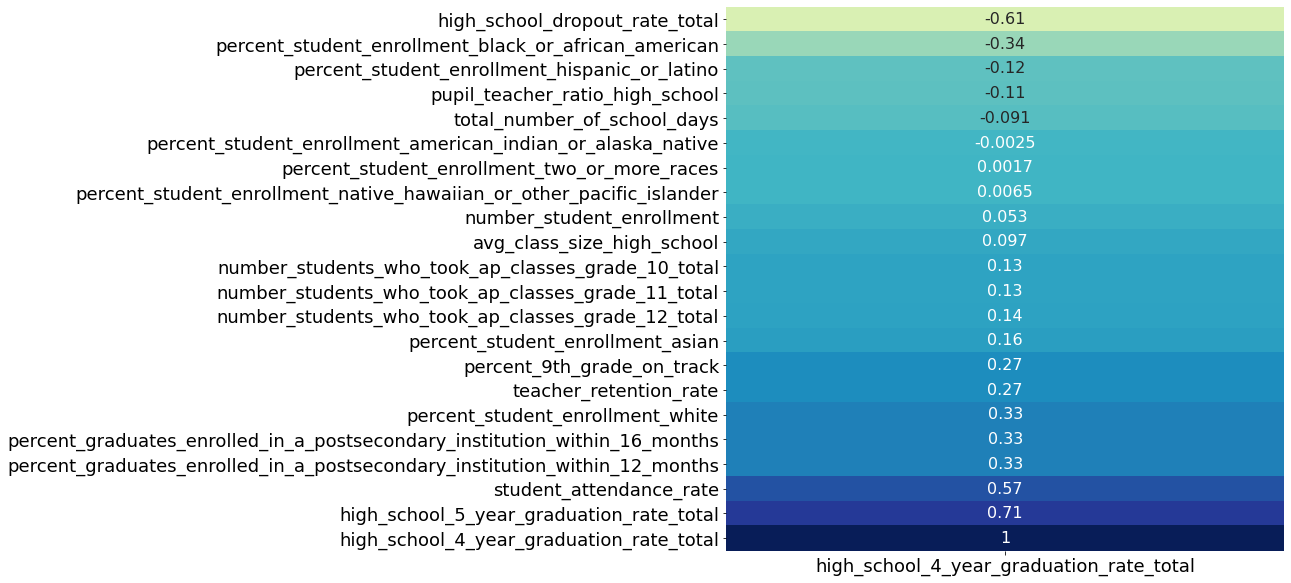

In [100]:
heatmap_numeric_w_dependent_variable(num_features, 'high_school_4_year_graduation_rate_total')
plt.savefig('figures/heatmap.png')
plt.show();

In [101]:
X = num_features.drop("high_school_4_year_graduation_rate_total", axis=1)
y = num_features["high_school_4_year_graduation_rate_total"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [102]:
lin_reg_model = LinearRegression()
baseline_cross_val_score = cross_val_score(lin_reg_model, X_train, y_train)
baseline_cross_val_score

array([0.51224706, 0.56788357, 0.62820087])

In [104]:
outcome = 'high_school_4_year_graduation_rate_total'
predictors = num_features.drop('high_school_4_year_graduation_rate_total', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=num_features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     high_school_4_year_graduation_rate_total   R-squared:                       0.596
Model:                                                  OLS   Adj. R-squared:                  0.594
Method:                                       Least Squares   F-statistic:                     237.5
Date:                                      Sat, 08 Aug 2020   Prob (F-statistic):               0.00
Time:                                              21:03:56   Log-Likelihood:                -12047.
No. Observations:                                      3403   AIC:                         2.414e+04
Df Residuals:                                          3381   BIC:                         2.427e+04
Df Model:                                                21                                         
Covariance Type:                                  nonrobust                                         
==============================================================================================================================================
                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    -48.6616    201.051     -0.242      0.809    -442.855     345.532
percent_student_enrollment_white                                               0.8080      2.004      0.403      0.687      -3.121       4.737
percent_student_enrollment_black_or_african_american                           0.7791      2.004      0.389      0.697      -3.149       4.708
percent_student_enrollment_hispanic_or_latino                                  0.7612      2.004      0.380      0.704      -3.168       4.690
percent_student_enrollment_asian                                               0.8842      2.004      0.441      0.659      -3.045       4.813
percent_student_enrollment_native_hawaiian_or_other_pacific_islander          -0.0242      2.120     -0.011      0.991      -4.180       4.132
percent_student_enrollment_american_indian_or_alaska_native                    0.4426      2.048      0.216      0.829      -3.572       4.457
percent_student_enrollment_two_or_more_races                                   0.6724      2.005      0.335      0.737      -3.258       4.603
number_student_enrollment                                                     -0.0003      0.000     -1.620      0.105      -0.001    6.89e-05
total_number_of_school_days                                                   -0.2294      0.064     -3.572      0.000      -0.355      -0.103
student_attendance_rate                                                        0.2722      0.050      5.486      0.000       0.175       0.369
high_school_dropout_rate_total                                                -0.4360      0.035    -12.551      0.000      -0.504      -0.368
high_school_5_year_graduation_rate_total                                       0.5581      0.019     28.911      0.000       0.520       0.596
avg_class_size_high_school                                                     0.0678      0.040      1.676      0.094      -0.012       0.147
pupil_teacher_ratio_high_school                                                0.2497      0.049      5.119      0.000       0.154       0.345
teacher_retention_rate                                                         0.0517      0.014      3.683      0.000       0.024       0.079
percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months     0.0364      0.068      0.539      0.590      

In [105]:
from sklearn.ensemble import RandomForestRegressor

rfr= RandomForestRegressor(random_state=42)

print(rfr.fit(X_train, y_train))
print(cross_val_score(rfr, X_train, y_train))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
[0.51990582 0.5774852  0.6119219 ]


In [106]:
rfr.predict(X_test)

array([40.61      , 88.61      , 93.75      , 91.04      , 94.1       ,
       96.25      , 92.23      , 92.47      , 93.41      , 87.36      ,
       93.5       , 95.64      , 87.47      , 85.66      , 87.79      ,
       88.18      , 93.54      , 93.95      , 72.64      , 86.05      ,
       84.28      , 90.87      , 79.85      , 83.18      , 85.03      ,
       87.45      , 93.17      , 80.73      , 90.15      , 65.84      ,
       81.28      , 88.57      , 93.57      , 95.47      , 40.17      ,
       89.84      , 37.46      , 89.21      , 95.09      , 39.46      ,
       82.28      , 87.42      , 90.34      , 93.44      , 85.16      ,
       85.89      , 93.02      , 56.03      , 76.5       , 81.66      ,
       67.07      , 87.32      , 84.77      , 95.66      , 91.31      ,
       86.11      , 78.71      , 94.89      , 75.08      , 95.        ,
       86.38      , 89.68      , 83.62      , 80.09      , 88.17      ,
       89.06      , 65.84      , 87.47      , 92.45      , 94.6 

In [107]:
cross_val_score(rfr, X_train, y_train)


array([0.51990582, 0.5774852 , 0.6119219 ])